## Part 1: Loading data, summary statistics, and plotting/correlations

In [50]:
!python --version

Python 3.10.12


In [64]:
# 1.
from datetime import datetime as dt, timezone
import pandas as pd
from numpy import argmax
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests
import json


charging_station_data = pd.read_csv('data/charging_station_data.tsv', sep='\t', encoding='ISO-8859-1')

charging_cols = [
	# unique identifiers
	'id',
	'station_name',

	# associate using date
	'open_date',

	# associate using location
	'country',
	'state',
	# 'city',

	# filter using status
	'status_code',
]
print(charging_station_data.head(10))

policy_data = pd.read_csv('data/transportation_policy_data.tsv', sep='\t', encoding='ISO-8859-1')
print(policy_data.head(10))

policy_cols = [
	# unique identifiers
	'id',
	'title',

	# associate using date
	'significant_update_date',

	# associate using location
	'state',

	# categorization
	'type',
	'categories'
]

parsed_date_col = 'parsed_date'

                        station_name   open_date    id date_last_confirmed  \
0           LADWP - Truesdale Center  1999-10-15  1517          2023-09-14   
1    LADWP - West LA District Office  2020-02-28  1519          2023-01-10   
2      Los Angeles Convention Center  1995-08-30  1523          2023-01-10   
3      LADWP - John Ferraro Building  1999-10-15  1525          2023-09-14   
4         LADWP - Haynes Power Plant  2018-05-01  1531          2023-01-10   
5  LADWP - Harbor Generating Station  1999-10-15  1552          2023-01-10   
6                LADWP - Sylmar West  2016-01-01  1556          2023-01-10   
7          LADWP - EV Service Center  1999-10-15  1572          2023-01-10   
8             LADWP - Fairfax Center  2019-04-01  1573          2023-01-10   
9     California Air Resources Board  1996-10-15  1583          2022-09-14   

  expected_date status_code            updated_at   facility_type  \
0          None           E  2023-09-14T14:01:49Z         UTILITY   
1  

In [70]:
def null_filtered(data, cols):
    mask = 1
    for col in cols:
        # mask &= data[col].notnull()
        mask &= (data[col].ne('None'))
    return data[mask].reset_index()

def get_formatted_date(data_slice, date_col, format: str):
    return [
        dt.strptime(date_str, format)
        for date_str in data_slice[date_col]
    ]

In [71]:
charging_station_data = null_filtered(charging_station_data, charging_cols)[charging_cols]
#charging_station_data = charging_station_data.mask(charging_station_data.astype(object).eq('None')).dropna()

In [72]:
charging_station_data['open_date'].value_counts()

2021-01-27    9055
2020-06-12    2843
2023-08-02    2259
2022-10-05    1049
2012-01-31     694
              ... 
2019-07-28       1
2021-12-05       1
2013-06-27       1
2013-12-03       1
2013-04-19       1
Name: open_date, Length: 3734, dtype: int64

In [73]:
charging_station_data[parsed_date_col] = get_formatted_date(
    charging_station_data,
    'open_date',
    '%Y-%m-%d'
)

In [74]:
# run summary statistics on charging station data
charging_station_data.info()
charging_station_data.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78383 entries, 0 to 78382
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            78383 non-null  object        
 1   station_name  78383 non-null  object        
 2   open_date     78383 non-null  object        
 3   country       78383 non-null  object        
 4   state         78383 non-null  object        
 5   status_code   78383 non-null  object        
 6   parsed_date   78383 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 4.2+ MB


,id,station_name,open_date,country,state,status_code,parsed_date
0,1517,LADWP - Truesdale Center,1999-10-15,US,CA,E,1999-10-15


In [75]:
policy_data = null_filtered(policy_data, policy_cols)[policy_cols]
# policy_data = policy_data.mask(policy_data.astype(object).eq('None')).dropna()

In [76]:
policy_data[parsed_date_col] = get_formatted_date(
    policy_data,
    'significant_update_date',
    '%m/%d/%Y'
)

In [77]:
policy_data.info()
policy_data.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       1127 non-null   int64         
 1   title                    1127 non-null   object        
 2   significant_update_date  1127 non-null   object        
 3   state                    1127 non-null   object        
 4   type                     1127 non-null   object        
 5   categories               1127 non-null   object        
 6   parsed_date              1127 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 61.8+ KB


,id,title,significant_update_date,state,type,categories,parsed_date
0,284,Congestion Mitigation and Air Quality (CMAQ) I...,11/29/2021,US,Incentives,"[{""code"": ""STATION"", ""title"": ""Alternative Fue...",2021-11-29


In [78]:
# helpers for plotting
def get_name(unformatted):
	return unformatted

def make_scatterplot(slice, x_col, y_col, title):
	sns.scatterplot(data=slice, x=x_col, y=y_col)
	plt.title(title)
	plt.xlabel(get_name(x_col))
	plt.ylabel(get_name(y_col))
	plt.show()

def make_boxplot(slice, x_col, y_col, title):
	sns.boxplot(data=slice, x=x_col, y=y_col)
	plt.title(title)
	plt.xlabel(get_name(x_col))
	plt.ylabel(get_name(y_col))
	plt.show()

def make_vertical_boxplot(slice, col, title):
	_, ax = plt.subplots(figsize=(6, 3), sharey=True, sharex=True)
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
	ax.spines['left'].set_visible(False)
	ax.set_title(title)
	ax.boxplot(slice[col])

def make_barplot(slice, x_col, y_col, x_label, y_label, title):
	sns.barplot(data=slice, x=x_col, y=y_col, hue=x_col, legend=False)
	plt.title(title)
	plt.xlabel(x_label)
	plt.ylabel(y_label)
	plt.xticks(rotation=45)
	plt.show()

def make_lineplot(slice, x_col, y_col, x_label, y_label, title):
	sns.lineplot(data=slice, x=x_col, y=y_col, legend=False)
	plt.title(title)
	plt.xlabel(x_label)
	plt.ylabel(y_label)
	plt.xticks(rotation=45)
	plt.show()

def filter_by_state(data_slice, state):
	return data_slice[data_slice['state'] == state].reset_index()

def filter_outliers(data_slice, col, limit):
	return data_slice[data_slice[col] < limit]

def group_by_year(data_slice, date_col):
	grouped_slice = data_slice.groupby(data_slice[date_col].dt.year).count()
	grouped_slice = grouped_slice.drop(columns=date_col)
	return grouped_slice

In [79]:
# Initial year-based correlations by state

stations_per_year_by_state = {}
policies_per_year_by_state = {}


# overall
us_stations = charging_station_data[charging_station_data['country'] == 'US']
us_stations = group_by_year(charging_station_data, parsed_date_col)
# make_barplot(
# 	us_stations,
# 	parsed_date_col,
# 	'id',
# 	'Year',
# 	'Charging Stations built',
# 	'Countrywide Stations'
# )

federal_policies = filter_by_state(policy_data, 'US')
federal_policies = group_by_year(policy_data, parsed_date_col)
# make_barplot(
# 	federal_policies,
# 	parsed_date_col,
# 	'id',
# 	'Year',
# 	'Policies Enacted',
# 	'Federal Policies'
# )

station_states = set(charging_station_data['state'])
policy_states = set(policy_data['state'])

# 50 US states plus washington DC that we have policy and station data for
state_intersections = station_states & policy_states

# Canadian provinces for which we have station data
# station_provinces = station_states - state_intersections

# by state
for state in sorted(state_intersections):
	# charging stations built by year by state
	state_stations = filter_by_state(
		charging_station_data,
		state
	)
	state_stations = group_by_year(state_stations, parsed_date_col)
	# make_barplot(
	# 	state_stations,
	# 	parsed_date_col,
	# 	'id',
	# 	'Year',
	# 	'Charging Stations built',
	# 	f'{state} Stations'
	# )
	stations_per_year_by_state[state] = state_stations

	# # policies enacted per year by state
	state_policies = filter_by_state(
		policy_data,
		state
	)
	state_policies = group_by_year(state_policies, parsed_date_col)
	# make_barplot(
	# 	state_policies,
	# 	parsed_date_col,
	# 	'id',
	# 	'Year',
	# 	'Policies Enacted',
	# 	f'{state} Policies'
	# )
	policies_per_year_by_state[state] = state_policies



In [80]:
# investigate policies by category: move fields in json objects into their own columns

codes_to_names = {
	# technology types
	'BIOD': 'Biodiesel',
	'ETH': 'Ethanol',
	'NG': 'Natural Gas',
	'LPG': 'Liquified Petroleum Gas',
	'HY': 'Hydrogen',
	'ELEC': 'Electric Vehicles',
	'PHEV': 'Plug-In Electric Hybrid Vehicles',
	'HEV': 'Hybrid Electric Vehicles',
	'NEVS': 'Neighborhood Electric Vehicles',
	'RD': 'Renewable Diesel',
	'AFTMKTCONV': 'Aftermarket Conversions',
	'EFFEC': 'Fuel Economy / Efficiency',
	'IR': 'Idle Reduction',
	'AUTONOMOUS': 'Autonomous Vehicles',

	# incentive types
	'GNT': 'Grants',
	'TAX': 'Tax Incentives',
	'LOANS': 'Loans and Leases',
	'RBATE': 'Rebates',
	'EXEM': 'Exemptions',
	'TOU': 'Time-of-Use Rate',

	# regulation types
	'REQ': 'Acquisition / Fuel Use',
	'DREST': 'Driving / Idling',
	'REGIS': 'Registration / Licensing',
	'EVFEE': 'EV Registration Fee',
	'FUEL': 'Fuel Taxes',
	'STD': 'Fuel Production / Quality',
	'RFS': 'Renewable Fuel Standard / Mandate',
	'AIRQEMISSIONS': 'Air Quality / Emissions',
	'CCEINIT': 'Climate Change / Energy Initiatives',
	'UTILITY': 'Utility Definition',
	'BUILD': 'Building Codes',
	'RTC': 'Right-to-Charge',

	# user types
	'FLEET': 'Commercial',
	'GOV': 'Government Entity',
	'TRIBAL':  'Tribal Government',
	'IND': 'Personal Vehicle Owner or Driver',
	'STATION': 'Alternative Fuel Infrastructure Operator',
	'AFP': 'Alternative Fuel Producer',
	'PURCH': 'Alternative Fuel Purchaser',
	'MAN': 'Manufacturer',
	'MUD': 'Multi-Unit Dwelling',
	'TRANS': 'Transit',

	'OTHER': 'Other',
}

def get_code_name(code):
	return codes_to_names[code]

policy_data['parsed_categories'] = policy_data['categories'].apply(json.loads)
category_types = set()
for categories in policy_data['parsed_categories']:
	for category in categories:
		category_types.add(category['category_type'])

category_cols = []
for category_type in category_types:
	def get_category_codes_by_type(entry):
		codes = set()
		for category in entry:
			if category['category_type'] == category_type:
				codes.add(category['code'])
		return codes if codes else None

	category_col = f'{category_type}_types'
	category_cols.append(category_col)
	policy_data[category_col] = policy_data['parsed_categories'].apply(get_category_codes_by_type)

types_slice = policy_data[list(map(lambda x: f'{x}_types', category_types))]
types_slice.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   incentive_types   636 non-null    object
 1   user_types        1118 non-null   object
 2   regulation_types  486 non-null    object
 3   tech_types        1127 non-null   object
dtypes: object(4)
memory usage: 35.3+ KB


In [81]:

# gather exhaustive set of code values observed for each field
unique_codes = {}
for col in category_cols:
	print(col)
	values = set()
	for code_set in policy_data[col]:
		values |= {get_code_name(code) for code in code_set} if code_set else set()
	print('{\n\t' + '\n\t'.join(values) + '\n}\n')
	unique_codes[col] = values


incentive_types
{
	Exemptions
	Loans and Leases
	Other
	Time-of-Use Rate
	Grants
	Tax Incentives
	Rebates
}

user_types
{
	Transit
	Alternative Fuel Infrastructure Operator
	Other
	Government Entity
	Commercial
	Alternative Fuel Purchaser
	Multi-Unit Dwelling
	Tribal Government
	Alternative Fuel Producer
	Personal Vehicle Owner or Driver
	Manufacturer
}

regulation_types
{
	EV Registration Fee
	Right-to-Charge
	Fuel Taxes
	Driving / Idling
	Registration / Licensing
	Air Quality / Emissions
	Other
	Building Codes
	Climate Change / Energy Initiatives
	Utility Definition
	Fuel Production / Quality
	Acquisition / Fuel Use
}

tech_types
{
	Aftermarket Conversions
	Idle Reduction
	Renewable Diesel
	Biodiesel
	Other
	Plug-In Electric Hybrid Vehicles
	Hydrogen
	Natural Gas
	Autonomous Vehicles
	Fuel Economy / Efficiency
	Liquified Petroleum Gas
	Hybrid Electric Vehicles
	Neighborhood Electric Vehicles
	Ethanol
	Electric Vehicles
}



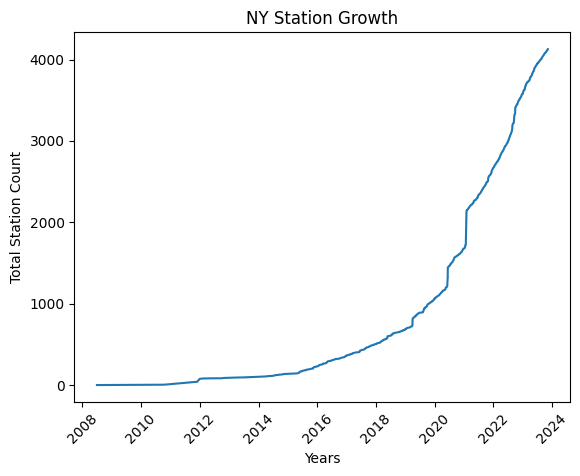

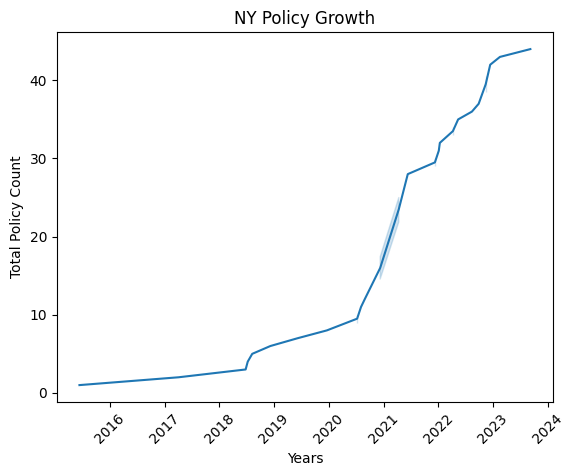

2015-06-12 00:00:00
2023-09-07 00:00:00


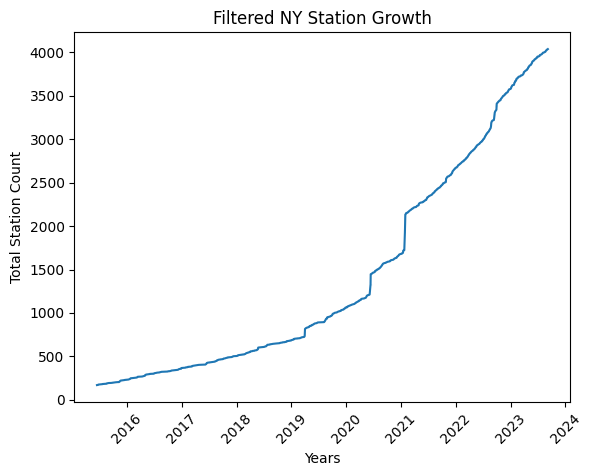

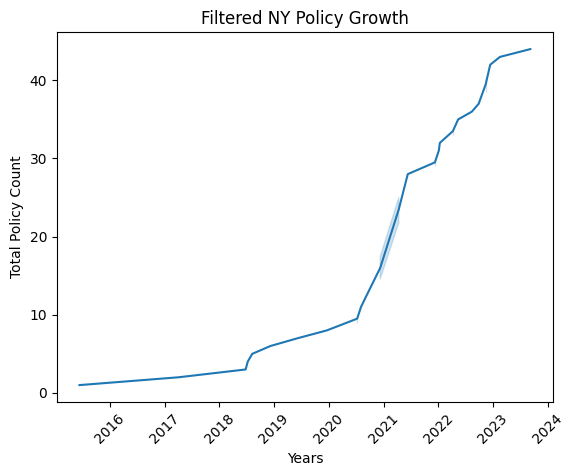


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0753  , p=0.0078  , df_denom=3865, df_num=1
ssr based chi2 test:   chi2=7.0808  , p=0.0078  , df=1
likelihood ratio test: chi2=7.0743  , p=0.0078  , df=1
parameter F test:         F=7.0753  , p=0.0078  , df_denom=3865, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0825  , p=0.9208  , df_denom=3862, df_num=2
ssr based chi2 test:   chi2=0.1652  , p=0.9207  , df=2
likelihood ratio test: chi2=0.1652  , p=0.9207  , df=2
parameter F test:         F=0.0825  , p=0.9208  , df_denom=3862, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3374  , p=0.0717  , df_denom=3859, df_num=3
ssr based chi2 test:   chi2=7.0250  , p=0.0711  , df=3
likelihood ratio test: chi2=7.0186  , p=0.0713  , df=3
parameter F test:         F=2.3252  , p=0.0729  , df_denom=3859, df_num=3

Granger Causality
number of lags (no zero) 4


InfeasibleTestError: ignored

In [85]:
# Simple initial test
def time_to_ts(date_obj):
	return date_obj.replace(tzinfo=timezone.utc).timestamp()

def diy_index(df):
	return list(range(1, df.shape[0] + 1))

def filter_entries_outside_date_range(df, start, end):
	mask = 1
	mask &= df[parsed_date_col] >= start
	mask &= df[parsed_date_col] <= end
	return df[mask]

charging_station_data['open_timestamp'] = charging_station_data[parsed_date_col].apply(time_to_ts)
# charging_station_data.head()
state = 'NY'
stations = filter_by_state(charging_station_data, state)[[parsed_date_col]].sort_values(by=parsed_date_col).reset_index()
stations['station_counts'] = diy_index(stations)

make_lineplot(
	stations,
	parsed_date_col,
	'station_counts',
	'Years',
	'Total Station Count',
	'NY Station Growth'
)
policies = filter_by_state(policy_data, state)[[parsed_date_col]].sort_values(by=parsed_date_col).reset_index()
policies['policy_counts'] = diy_index(policies)
make_lineplot(
	policies,
	parsed_date_col,
	'policy_counts',
	'Years',
	'Total Policy Count',
	'NY Policy Growth'
)

highest_start_date = max(stations[parsed_date_col][0], policies[parsed_date_col][0])
print(highest_start_date)
lowest_end_date = min(stations[parsed_date_col][stations.shape[0]-1], policies[parsed_date_col][policies.shape[0]-1])
print(lowest_end_date)

stations = filter_entries_outside_date_range(stations, highest_start_date, lowest_end_date)
policies = filter_entries_outside_date_range(policies, highest_start_date, lowest_end_date)


make_lineplot(
	stations,
	parsed_date_col,
	'station_counts',
	'Years',
	'Total Station Count',
	'Filtered NY Station Growth'
)

make_lineplot(
	policies,
	parsed_date_col,
	'policy_counts',
	'Years',
	'Total Policy Count',
	'Filtered NY Policy Growth'
)

merged_data = pd.merge_asof(stations, policies, on=parsed_date_col)
# merged_data['pct_diff_station_counts'] = merged_data['station_counts'].pct_change()
# merged_data['pct_diff_policy_counts'] = merged_data['policy_counts'].pct_change()
# merged_data = merged_data.dropna()
# merged_data.head()
merged_data = merged_data[['station_counts', 'policy_counts']].pct_change().dropna()

# make_lineplot(
# 	merged_data,
# 	parsed_date_col,
# 	'pct_diff_station_counts',
# 	'Years',
# 	'% Change in Station Count',
# 	'NY Station Growth Rate'
# )

# make_lineplot(
# 	merged_data,
# 	parsed_date_col,
# 	'pct_diff_policy_counts',
# 	'Years',
# 	'% Change in Policy Count',
# 	'NY Policy Growth Rate'
# )

results = grangercausalitytests(merged_data, 4)
# for lag in sorted(results.keys()):
# 	lag_res, _ = results[lag]
# 	print(f'results with lag={lag}: {lag_res}')
